### 기존 논문(VAEP)에서 제안한 catboost과 얼마나 다를까?

- 정성적인 평가는 사실 객관적인 의견뿐 아니라 주관적인 의견도 들어가는 점 양해바랍니다.
- 특히, 딥러닝의 경우 블랙박스 모델이기 때문에 예측 결과가 왜 이렇게 나왔는지 분석하기가 어렵다.

In [34]:
import sys
import os

# 현재 디렉토리의 상위 폴더 경로를 구합니다.
# matplotsoccer를 설치(pip)해서 라이브러리르 사용할 수 있지만, 본 연구에서는 좀 더 시각적으로 설명하기 위해 라이브러리를 조금 수정해보았다
parent_dir = os.path.dirname(os.getcwd())

# 상위 폴더 경로를 sys.path에 추가합니다.
sys.path.insert(0, parent_dir)

In [35]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [36]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import matplotsoccer
import matplotlib.pyplot as plt

In [38]:
folder = 'multiclass-data'    
X_test = pd.read_csv(f'../data/{folder}/test/X_test.csv')
Y_test = pd.read_csv(f'../data/{folder}/test/Y_test.csv')

print(X_test.shape, Y_test.shape)

multiclass_dcn_probability = pd.read_csv('./result/multiclass_prediction.csv')
multiclass_dcn_probability = multiclass_dcn_probability[['scores','concedes']]
multiclass_dcn_probability

(82108, 161) (82108, 1)


,scores,concedes
0,0.007327,0.101461
1,0.003211,0.087956
2,0.007094,0.219455
3,0.000777,0.105735
4,0.003963,0.073901
...,...,...
82103,0.192851,0.156404
82104,0.000165,0.971769
82105,0.642006,0.087835
82106,0.000139,0.730931


#### 예측한 multiclass_dcn_probability를 경기별로 매칭시켜서 새로 저장

- binary_dcn_probability도 수행해보고 싶은 분들은 ML_Binary_VAEP.ipynb를 copy한 후에 폴더 경로만 바꿔주시면 됩니다.

In [39]:
spadl_datafolder = "../data-fifa/La Liga/spadl-statsbomb/"
test_spadl_h5 = os.path.join(spadl_datafolder, "test_competitions.h5")

test_predictions_h5 = os.path.join("./result/multiclass_predictions.h5")

In [40]:
with pd.HDFStore(test_spadl_h5) as spadlstore:
    test_games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]

print("nb of games:", len(test_games))
test_games.head()

nb of games: 35


,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee,competition_name,country_name,competition_gender,season_name,home_team_name,away_team_name
0,3773386,90,11,Regular Season,8,2020-10-31 21:00:00,206,217,1,1,Estadio de Mendizorroza,NaN,La Liga,Spain,male,2020/2021,Deportivo Alavés,Barcelona
1,3773565,90,11,Regular Season,18,2021-01-09 18:30:00,1049,217,0,4,Estadio Nuevo Los Cármenes,Ricardo De Burgos Bengoetxea,La Liga,Spain,male,2020/2021,Granada,Barcelona
2,3773457,90,11,Regular Season,37,2021-05-16 18:30:00,217,209,1,2,Spotify Camp Nou,NaN,La Liga,Spain,male,2020/2021,Barcelona,Celta Vigo
3,3773631,90,11,Regular Season,22,2021-02-07 21:00:00,218,217,2,3,Estadio Benito Villamarín,NaN,La Liga,Spain,male,2020/2021,Real Betis,Barcelona
4,3773665,90,11,Regular Season,26,2021-03-06 21:00:00,422,217,0,2,Estadio El Sadar,Guillermo Cuadra Fernández,La Liga,Spain,male,2020/2021,Osasuna,Barcelona


In [41]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(test_games.game_id, "Loading game ids"):
    Ai = pd.read_hdf(test_spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, multiclass_dcn_probability], axis=1).groupby("game_id")

with pd.HDFStore(test_predictions_h5) as predictionstore:
    for k, df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
        df = df.reset_index(drop=True)
        predictionstore.put(f"game_{int(k)}", df[multiclass_dcn_probability.columns])

Saving predictions per game: 100%|██████████| 35/35 [00:00<00:00, 252.99it/s]


## Compute VAEP

- 주어진 multiclass_dcn_probability를 VAEP에 적용
- 득점, 실점 예측확률값 & 기존 이벤트 데이터(위치, 행동 유형, 행동결과)를 매칭

In [42]:
test_actions = []

for game in tqdm.tqdm(list(test_games.itertuples()), desc="Rating actions"): 
    actions = pd.read_hdf(test_spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(test_predictions_h5, f"game_{game.game_id}")
    
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    test_actions.append(pd.concat([actions, preds, values], axis=1))
    
test_actions = pd.concat(test_actions).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
test_actions.columns

Rating actions:  11%|█▏        | 4/35 [00:00<00:00, 36.16it/s]

Rating actions: 100%|██████████| 35/35 [00:00<00:00, 36.67it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [43]:
test_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_name,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,3764440,23743e50-fbe4-4929-938e-9b3ab39ff4ff,1,0.0,1042,12072.0,52.058824,33.655696,62.470588,42.435443,...,success,foot_left,Pere Milla Peña,Pere Milla,Elche,0.003666,0.069779,0.000000,-0.000000,0.000000
1,3764440,937db060-0bc2-45d9-9bf1-fd365840c580,1,1.0,1042,24517.0,62.470588,42.435443,61.676471,43.382278,...,success,foot,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.006057,0.081858,0.002391,-0.012079,-0.009688
2,3764440,df248b0b-baeb-4bf0-9557-062682814138,1,1.0,1042,24517.0,61.676471,43.382278,76.411765,38.820253,...,success,foot_right,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.000274,0.082848,-0.005782,-0.000989,-0.006772
3,3764440,3f30f412-a641-40c9-9a11-9716b039a566,1,3.0,1042,24169.0,76.411765,38.820253,75.617647,38.131646,...,success,foot,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.000676,0.115209,0.000401,-0.032362,-0.031960
4,3764440,934bd267-dcf8-4f0f-aa6b-ce68cbe9397d,1,4.0,1042,24169.0,75.617647,38.131646,74.911765,14.891139,...,success,foot_right,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.000618,0.109900,-0.000058,0.005309,0.005251


## Analyse VAEP ratings
### Most valuable players

- VAEP를 통한 통계량 추정

- 선수 id별 team_name기록(한 시즌에 두팀에서 뛴 선수까지 고려)

In [44]:
player_team = dict()
for (id,team) in test_actions[['player_id', 'team_name']].values:
    if id in player_team.keys():
        #한 시즌에 두팀에서 뛴 경우 두 팀 모두 기록
        if team not in player_team[id]:
            player_team[id]+= f' / {team}'
    else:
        player_team[id] = team
player_team[24730.0]

'Celta Vigo / Real Valladolid'

### 모든 이벤트를 전부 고려했을 때, VAEP의 합은 어느 선수가 가장 높을까?

- 2020/2021시즌이 Messi의 전성기 시절이 한참 지나긴 했지만, 상위 랭크에 Messi가 보이지 않는다는 것은 의심해볼 사항이긴 함.
- 기존 ML_VAEP에서는 바르셀로나의 경기수/이벤트 횟수가 많음에 따라 VAEP의 합은 바르셀로나 선수가 대부분 랭크를 차지했음
- 그러나, Multiclass-DCN에서는 경기수가 많은 바르셀로나의 선수가 랭크에 포함되어 있지 않음

## 원인?

- 처음에 말했듯이 딥러닝은 블랙박스 모델이므로 예측의 원인을 정확하게 파악하는 것은 어렵다.
- 나의 연구 분석상 딥러닝은 대부분의 액션에 대해서 VAEP를 굉장히 낮게 부여하는 것을 확인할 수 있었다.
- 실제로 매우 잘한 플레이를 제외하면 대부분 VAEP가 낮거나 음수값을 보인다.

In [45]:
test_actions["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    test_actions[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)

# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR['team_name'] = playersR['player_id'].apply(lambda id : player_team[id])

playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name
57,5574.0,Toni Kroos,3.084190,7.293865,-4.209676,227,Real Madrid
369,41083.0,Rodri,2.538205,1.598904,0.939301,38,Real Betis
148,6782.0,Enis Bardhi,1.703531,3.849095,-2.145564,72,Levante UD
359,34323.0,Luismi Sánchez,1.488825,0.574272,0.914553,10,Elche
136,6733.0,Pedro Mosquera,1.375475,1.236870,0.138605,93,Huesca
185,7030.0,Raúl Albiol,1.373548,0.426398,0.947149,198,Villarreal
354,32185.0,Álex Remiro,1.050923,4.328939,-3.278015,117,Real Sociedad
197,8652.0,Jasper Cillessen,1.019615,2.171737,-1.152122,55,Valencia
229,12419.0,Lucas Torró,0.757916,0.163412,0.594504,66,Osasuna
308,24169.0,Gonzalo Verdú,0.716830,1.597550,-0.880719,105,Elche


### 경기를 뛴 시간대비 어느 선수가 VAEP가 가장 높을까?

- 경기를 뛴 시간(minute)대비 얼마나 가치 있는(VAEP가 높은)플레이를 수행했는지 분석
- Messi의 VAEP음수가 나오는 이유가 defensive_value가 굉장히 낮아서 발생하는현상인 것 같다. 
- 우리는 vaep_value, offensivae_value, defensive_value가 아닌 by_minute를 기준으로 산출한 지표를 봐야한다.
- vaep_value는 단순히 각 선수가 수행한 이벤트의 vaep의 합이므로 많이 띈 선수가 높은 vaep를 받을 수 있으므로 vaep_by_minute를 확인해보자

### 각 선수별 포지션 

1. Álex Remiro (Real Sociedad) - 골키퍼
2. Unai Simón (Athletic Club) - 골키퍼
3. Lionel Messi (Barcelona) - 공격수 또는 공격형 미드필더
4. Koke (Atlético Madrid) - 중앙 미드필더
5. Sergio Herrera (Osasuna) - 골키퍼
6. Yassine Bounou (Sevilla) - 골키퍼
7. Marc-André ter Stegen (Barcelona) - 골키퍼
8. Neto (Barcelona) - 골키퍼
9. Jan Oblak (Atlético Madrid) - 골키퍼
10. Pau Torres (Villarreal) - 수비수

- 띈 시간 대비 VAEP는 대부분 골키퍼가 랭크되어있는 것을 확인할 수 있음

In [47]:
# Normalize for minutes played
pg = pd.read_hdf(test_spadl_h5, "player_games")
pg = pg[pg.game_id.isin(test_games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_by_minutes"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_by_minutes"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_by_minutes"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_by_minutes",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name,minutes_played,vaep_by_minutes,offensive_by_minutes,defensive_by_minutes
354,32185.0,Álex Remiro,1.050923,4.328939,-3.278015,117,Real Sociedad,190,0.497806,2.050550,-1.552744
224,11748.0,Unai Simón,0.674129,0.736698,-0.062569,98,Athletic Club,188,0.322721,0.352674,-0.029953
52,5503.0,Lionel Messi,-6.175928,150.121171,-156.297099,5435,Barcelona,3191,-0.174188,4.234066,-4.408254
35,5199.0,Koke,-0.412410,4.231288,-4.643698,277,Atlético Madrid,192,-0.193317,1.983416,-2.176734
310,24211.0,Sergio Herrera,-1.708044,3.308937,-5.016981,118,Osasuna,187,-0.822053,1.592536,-2.414590
150,6785.0,Yassine Bounou,-1.906737,0.113065,-2.019802,149,Sevilla,188,-0.912800,0.054127,-0.966927
251,20055.0,Marc-André ter Stegen,-45.359612,-26.716307,-18.643305,1761,Barcelona,2746,-1.486659,-0.875625,-0.611033
87,6590.0,Neto,-10.331498,-6.824111,-3.507387,346,Barcelona,577,-1.611499,-1.064419,-0.547079
68,6378.0,Jan Oblak,-4.289857,0.538342,-4.828199,82,Atlético Madrid,192,-2.010871,0.252348,-2.263218
172,6892.0,Pau Torres,-4.640714,-1.154392,-3.486322,217,Villarreal,188,-2.221618,-0.552635,-1.668984


### 이벤트 하나하나에 있어서 어느 선수가 VAEP가 가장 높을까?

- Trincão, Kroos선수는 이벤트를 수행한 횟수가 6, 76번으로 적은 편에 속하는 것을 확인할 수 있다.
- 그러나 각 이벤트하나하나에 굉장히 높은 VAEP를 추출하는 것을 확인할 수 있다
- 이는 Trincão선수가 공을 잡으면 가치 있는 플레이를 할 확률이 높기 때문에 우리는 그가 공을 잡지 못하도록 견제해야한다.

### 각 선수별 포지션 

1. Francisco Trincão (Barcelona) - 공격수 또는 공격형 미드필더
2. Toni Kroos (Real Madrid) - 중앙 미드필더
3. Clément Lenglet (Barcelona) - 수비수
4. Karim Benzema (Real Madrid) - 공격수
5. Ronald Araújo (Barcelona) - 수비수
6. Pedri (Barcelona) - 공격형 미드필더
7. Sergio Busquets (Barcelona) - 중앙 미드필더 (수비형 미드필더)
8. Thibaut Courtois (Real Madrid) - 골키퍼
9. Óscar Mingueza (Barcelona) - 수비수
10. Lionel Messi (Barcelona) - 공격수 또는 공격형 미드필더

- 포지션별 VAEP가 골고루 분포되어 있음

In [54]:
stats["vaep_by_minutes_count"] = stats.vaep_value * 90 / stats['count']
stats["offensive_by_minutes_count"] = stats.offensive_value * 90 / stats['count']
stats["defensive_by_minutes_count"] = stats.defensive_value * 90 / stats['count']
stats.sort_values("vaep_by_minutes_count",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name,minutes_played,vaep_by_minutes,offensive_by_minutes,defensive_by_minutes,vaep_by_minutes_count,offensive_by_minutes_count,defensive_by_minutes_count
27,22390.0,Francisco Trincão,0.633085,0.401846,0.231238,6,Barcelona,14,4.069829,2.583298,1.486532,9.496268,6.027694,3.468574
15,5574.0,Toni Kroos,3.916112,3.548833,0.367279,76,Real Madrid,73,4.828083,4.375274,0.452810,4.637501,4.202565,0.434936
20,6826.0,Clément Lenglet,2.332074,3.812810,-1.480735,190,Barcelona,96,2.186319,3.574509,-1.388190,1.104667,1.806068,-0.701401
24,19677.0,Karim Benzema,0.029149,2.223454,-2.194305,58,Real Madrid,73,0.035937,2.741245,-2.705308,0.045231,3.450187,-3.404956
29,32480.0,Ronald Araújo,-0.781594,-0.847991,0.066397,98,Barcelona,73,-0.963609,-1.045469,0.081860,-0.717790,-0.778767,0.060977
28,30486.0,Pedri,-1.861957,1.383364,-3.245321,129,Barcelona,82,-2.043612,1.518326,-3.561938,-1.299040,0.965137,-2.264177
7,5203.0,Sergio Busquets,-3.377549,0.650552,-4.028101,164,Barcelona,65,-4.676606,0.900765,-5.577371,-1.853533,0.357010,-2.210543
1,3509.0,Thibaut Courtois,-1.661077,1.959563,-3.620641,50,Real Madrid,96,-1.557260,1.837091,-3.394351,-2.989939,3.527214,-6.517153
31,43728.0,Óscar Mingueza,-5.833323,-2.250900,-3.582423,167,Barcelona,96,-5.468740,-2.110219,-3.358521,-3.143707,-1.213060,-1.930647
12,5503.0,Lionel Messi,-6.265423,1.947211,-8.212635,176,Barcelona,96,-5.873834,1.825511,-7.699345,-3.203910,0.995733,-4.199643


### 아래 그림은 레알마드리드 vs 바르셀로나 경기에서 레알 마드리가 첫번째 골을 넣은 과정을 시각화한것이다.

- 일부코드는 해당 경기의 과정을 시각화하기위해 쿼리를 작성함(조건절을 빼고 작성시 다양한 용도로 활용가능)
- https://www.youtube.com/watch?v=EhodpjwTtag&t=1986s
- ML(catboost)과는 다르게 슛팅에 높은 VAEP를 부여하지 않고, 오히려 과정에서 발베르데(Valverde)의 드리블에 높은 VAEP를 부여함
- 즉, 딥러닝은 골의 마무리를 하는 슛팅보다는 그 전에 만들어지는 과정에 더 높은 VAEP를 부여하는 것을 확인할 수 있음
- 실제로, 포지션별 VAEP도 위에서 확인했다시피 공격수가 상위랭크에 부여한 ML_VAEP과는 다르게 DL_VAEP는 미드필더(ex.Kroos)에게 높은 VAEP를 부여하는 것을 확인함

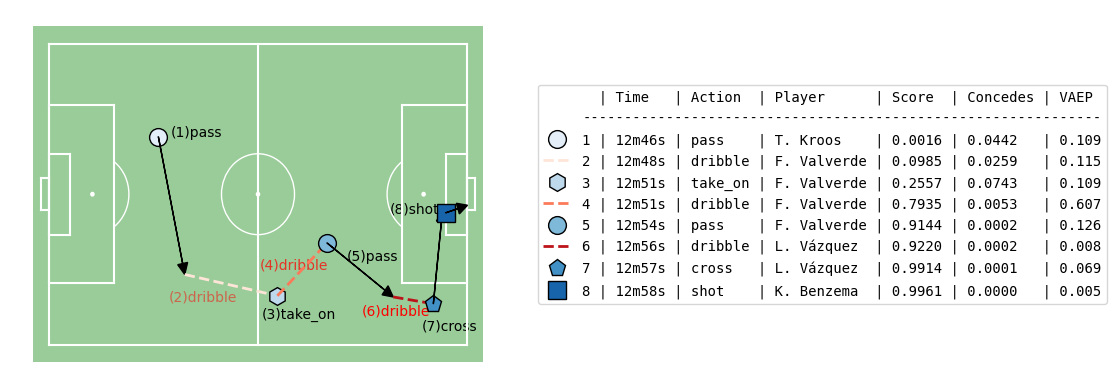

In [49]:
sorted_A = test_actions
sorted_A = sorted_A[(sorted_A.time_seconds>775.0) & (sorted_A.time_seconds<780.0)]
sorted_A = sorted_A[sorted_A.game_id==3773497]
sorted_A = sorted_A[sorted_A.team_name == "Real Madrid"]


def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 1):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = test_actions[i - 5 : i+3].copy()
    
    
    result = False
    for vaep, team in zip(a['vaep_value'],a['team_name']):
        if (team !="Real Madrid"):
            result = True

    if result:
        continue
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1],axis=1)
    a['type_name'] = a['type_name'].replace("_"," ")
    
    for index, name in zip(a.index,a['player_name']):
        name_lst = name.split()
        first_name = name_lst[0][0] + ". "
        last_name = name_lst[-1]

        a.loc[index,'player_name'] = first_name + last_name
    
    g = list(test_games[test_games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)

    a["scores"] = a.scores.apply(lambda x : "%.4f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.4f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)

    cols = ["time", "type_name", "player_name","scores", "concedes","vaep_value"]
    t = "시간"

    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle =  ["Time", "Action", "Player","Score", "Concedes","VAEP"],
                zoom=False,
                color="green")
   


### 아래 그림은 레알마드리드 vs 바르셀로나 경기에서 누가 가장 VAEP가 높은 이벤트를 수행했을까?

In [50]:
A = test_actions.copy()
A = A[A.game_id==3773497]

A.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
32842,3773497,4bb5ef98-f35a-46a0-86d2-4300f39bdce7,1,0.0,217,5503.0,52.058824,33.655696,61.411765,37.529114,...,foot_left,Lionel Andrés Messi Cuccittini,Lionel Messi,Barcelona,0.008192,0.099150,0.000000,-0.000000,0.000000,1
32843,3773497,bfa793ab-d82a-487a-86f0-e82e477a4add,1,1.0,217,5203.0,61.411765,37.529114,60.176471,35.893671,...,foot,Sergio Busquets i Burgos,Sergio Busquets,Barcelona,0.015685,0.120436,0.007494,-0.021286,-0.013792,1
32844,3773497,5f18fc92-4412-47db-80fe-8bb3d78da122,1,3.0,217,5203.0,60.176471,35.893671,67.147059,23.240506,...,foot_right,Sergio Busquets i Burgos,Sergio Busquets,Barcelona,0.002454,0.104669,-0.013231,0.015768,0.002536,1
32845,3773497,4cd38a62-7853-44a4-a53d-06c946aaa95e,1,5.0,217,6826.0,67.147059,23.240506,67.941176,22.207595,...,foot,Clément Lenglet,None,Barcelona,0.003362,0.214778,0.000909,-0.110110,-0.109201,1
32846,3773497,f92ab228-1310-448b-83d0-86a44ff555a1,1,6.0,217,6826.0,67.941176,22.207595,58.764706,23.756962,...,foot_left,Clément Lenglet,None,Barcelona,0.030268,0.101084,0.026906,0.113694,0.140600,1


### 모든 이벤트를 전부 고려했을 때, VAEP의 합은 어느 선수가 가장 높을까?

- Toni Kroos(토니 크로스, 미드필더)가 가장 VAEP의 합을 높게 차지함

In [51]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)

# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR['team_name'] = playersR['player_id'].apply(lambda id : player_team[id])

playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name
15,5574.0,Toni Kroos,3.916112,3.548833,0.367279,76,Real Madrid
20,6826.0,Clément Lenglet,2.332074,3.812810,-1.480735,190,Barcelona
27,22390.0,Francisco Trincão,0.633085,0.401846,0.231238,6,Barcelona
24,19677.0,Karim Benzema,0.029149,2.223454,-2.194305,58,Real Madrid
29,32480.0,Ronald Araújo,-0.781594,-0.847991,0.066397,98,Barcelona
14,5552.0,Marcelo,-1.003776,-0.899610,-0.104166,14,Real Madrid
1,3509.0,Thibaut Courtois,-1.661077,1.959563,-3.620641,50,Real Madrid
3,4447.0,Martin Braithwaite,-1.691497,-1.199144,-0.492352,4,Barcelona
28,30486.0,Pedri,-1.861957,1.383364,-3.245321,129,Barcelona
11,5487.0,Antoine Griezmann,-3.217355,-0.508282,-2.709073,45,Barcelona


### 경기를 뛴 시간대비 어느 선수가 VAEP가 가장 높을까?

- ML_VAEP과 고통적으로 Toni Kroos가 VAEP가 가장 높은 것을 확인할 수 있음
- 공격수/공격형 미드필더(Trincao, Benzema, Pedri)가 랭크에 속하는데, 기존 ML_VAEP과는 다르게 상대적으로 마무리를 담당하는 선수가 랭크에 적음
- 즉, DL_VAEP는 슛에만 높은 VAEP를 부여하는 ML_VAEP과 다르게 미드필더 라인에서 공을 패스하고, 드리블하는 선수의 가치도 높게 평가한다.

In [52]:
# Normalize for minutes played
pg = pd.read_hdf(test_spadl_h5, "player_games")
pg = pg[pg.game_id.isin([3773497])]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)

col = ['player_id', 'player_name', 'vaep_value', 'count', 'team_name', 'minutes_played', 'vaep_by_minutes']
stats["vaep_by_minutes"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_by_minutes"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_by_minutes"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_by_minutes",ascending=False)[:10][col]

,player_id,player_name,vaep_value,count,team_name,minutes_played,vaep_by_minutes
15,5574.0,Toni Kroos,3.916112,76,Real Madrid,73,4.828083
27,22390.0,Francisco Trincão,0.633085,6,Barcelona,14,4.069829
20,6826.0,Clément Lenglet,2.332074,190,Barcelona,96,2.186319
24,19677.0,Karim Benzema,0.029149,58,Real Madrid,73,0.035937
29,32480.0,Ronald Araújo,-0.781594,98,Barcelona,73,-0.963609
1,3509.0,Thibaut Courtois,-1.661077,50,Real Madrid,96,-1.557260
28,30486.0,Pedri,-1.861957,129,Barcelona,82,-2.043612
14,5552.0,Marcelo,-1.003776,14,Real Madrid,23,-3.927821
7,5203.0,Sergio Busquets,-3.377549,164,Barcelona,65,-4.676606
21,8118.0,Frenkie de Jong,-5.420352,152,Barcelona,96,-5.081580


### 이벤트 하나하나에 있어서 어느 선수가 VAEP가 가장 높을까?

- Francisco Trincão	가 매우 높은 VAEP를 갖는 것을 확인함

In [53]:
col = ['player_id', 'player_name', 'vaep_value', 'count', 'team_name', 'minutes_played', 'vaep_by_minutes','vaep_by_minutes_count']
stats["vaep_by_minutes_count"] = stats.vaep_value * 90 / stats['count']
stats["offensive_by_minutes_count"] = stats.offensive_value * 90 / stats['count']
stats["defensive_by_minutes_count"] = stats.defensive_value * 90 / stats['count']
stats.sort_values("vaep_by_minutes_count",ascending=False)[:10][col]

,player_id,player_name,vaep_value,count,team_name,minutes_played,vaep_by_minutes,vaep_by_minutes_count
27,22390.0,Francisco Trincão,0.633085,6,Barcelona,14,4.069829,9.496268
15,5574.0,Toni Kroos,3.916112,76,Real Madrid,73,4.828083,4.637501
20,6826.0,Clément Lenglet,2.332074,190,Barcelona,96,2.186319,1.104667
24,19677.0,Karim Benzema,0.029149,58,Real Madrid,73,0.035937,0.045231
29,32480.0,Ronald Araújo,-0.781594,98,Barcelona,73,-0.963609,-0.717790
28,30486.0,Pedri,-1.861957,129,Barcelona,82,-2.043612,-1.299040
7,5203.0,Sergio Busquets,-3.377549,164,Barcelona,65,-4.676606,-1.853533
1,3509.0,Thibaut Courtois,-1.661077,50,Real Madrid,96,-1.557260,-2.989939
31,43728.0,Óscar Mingueza,-5.833323,167,Barcelona,96,-5.468740,-3.143707
12,5503.0,Lionel Messi,-6.265423,176,Barcelona,96,-5.873834,-3.203910
